In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import os
import scienceplots
from styles import set_plot_style
import re

set_plot_style("prism_rain")



In [4]:
# plot_ber_scenarios.py

import os
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df_uncoded = pd.read_csv("BER_sweep_results_noncoded.csv")
df_bch     = pd.read_csv("BER_sweep_results_bch_1.csv")

# Parameters
modulations    = sorted(df_uncoded["modulation"].unique())
pilot_spacings = sorted(df_uncoded["pilot_spacing"].unique())
scenarios_u    = set(df_uncoded["scenario"].unique())
scenarios_b    = set(df_bch["scenario"].unique())
scenarios      = sorted(scenarios_u.union(scenarios_b))

os.makedirs("figures_p3", exist_ok=True)

for M in modulations:
    for P in pilot_spacings:
        for scen in scenarios:
            # filter both datasets
            df_u = df_uncoded.query(
                "modulation==@M and pilot_spacing==@P and scenario==@scen"
            )
            df_b = df_bch.query(
                "modulation==@M and pilot_spacing==@P and scenario==@scen"
            )
            if df_u.empty and df_b.empty:
                continue

            # pivot tables
            tbl_u = (
                df_u
                .pivot_table(index="snr_db", columns="method", values="ber")
                .sort_index()
            )
            tbl_b = (
                df_b
                .pivot_table(index="snr_db", columns="method", values="ber")
                .sort_index()
            )

            plt.figure(figsize=(10, 7))

            # plot uncoded
            for method in ["perfect", "cubic"]:
                if method in tbl_u.columns:
                    plt.semilogy(
                        tbl_u.index,
                        tbl_u[method],
                        marker="o",
                        label=f"Uncoded {method.capitalize()}"
                    )
            # plot BCH‐coded
            for method in ["perfect", "cubic"]:
                if method in tbl_b.columns:
                    plt.semilogy(
                        tbl_b.index,
                        tbl_b[method],
                        marker="s",
                        label=f"BCH-coded {method.capitalize()}"
                    )

            plt.grid(True, which="both", ls=":")
            plt.xlabel("$E_b/N_0$ (dB)")
            plt.ylabel("Bit Error Rate")
            plt.title(f"M={M}, P={P}, scenario={scen}")
            plt.legend()
            plt.tight_layout()

            outpath = os.path.join("figures_p3", f"BER_{scen}_P{P}_M{M}.png")
            plt.savefig(outpath)
            plt.close()
            print(f"→ saved {outpath}")


→ saved figures_p3/BER_doppler_p10_v50_f3500MHz_P5_M4.png
→ saved figures_p3/BER_doppler_p10_v50_f700MHz_P5_M4.png
→ saved figures_p3/BER_doppler_p10_v50_f3500MHz_P10_M4.png
→ saved figures_p3/BER_doppler_p10_v50_f700MHz_P10_M4.png
→ saved figures_p3/BER_doppler_p10_v50_f3500MHz_P5_M16.png
→ saved figures_p3/BER_doppler_p10_v50_f700MHz_P5_M16.png
→ saved figures_p3/BER_doppler_p10_v50_f3500MHz_P10_M16.png
→ saved figures_p3/BER_doppler_p10_v50_f700MHz_P10_M16.png


→ saved figures_p3/BER_all_subplots.png


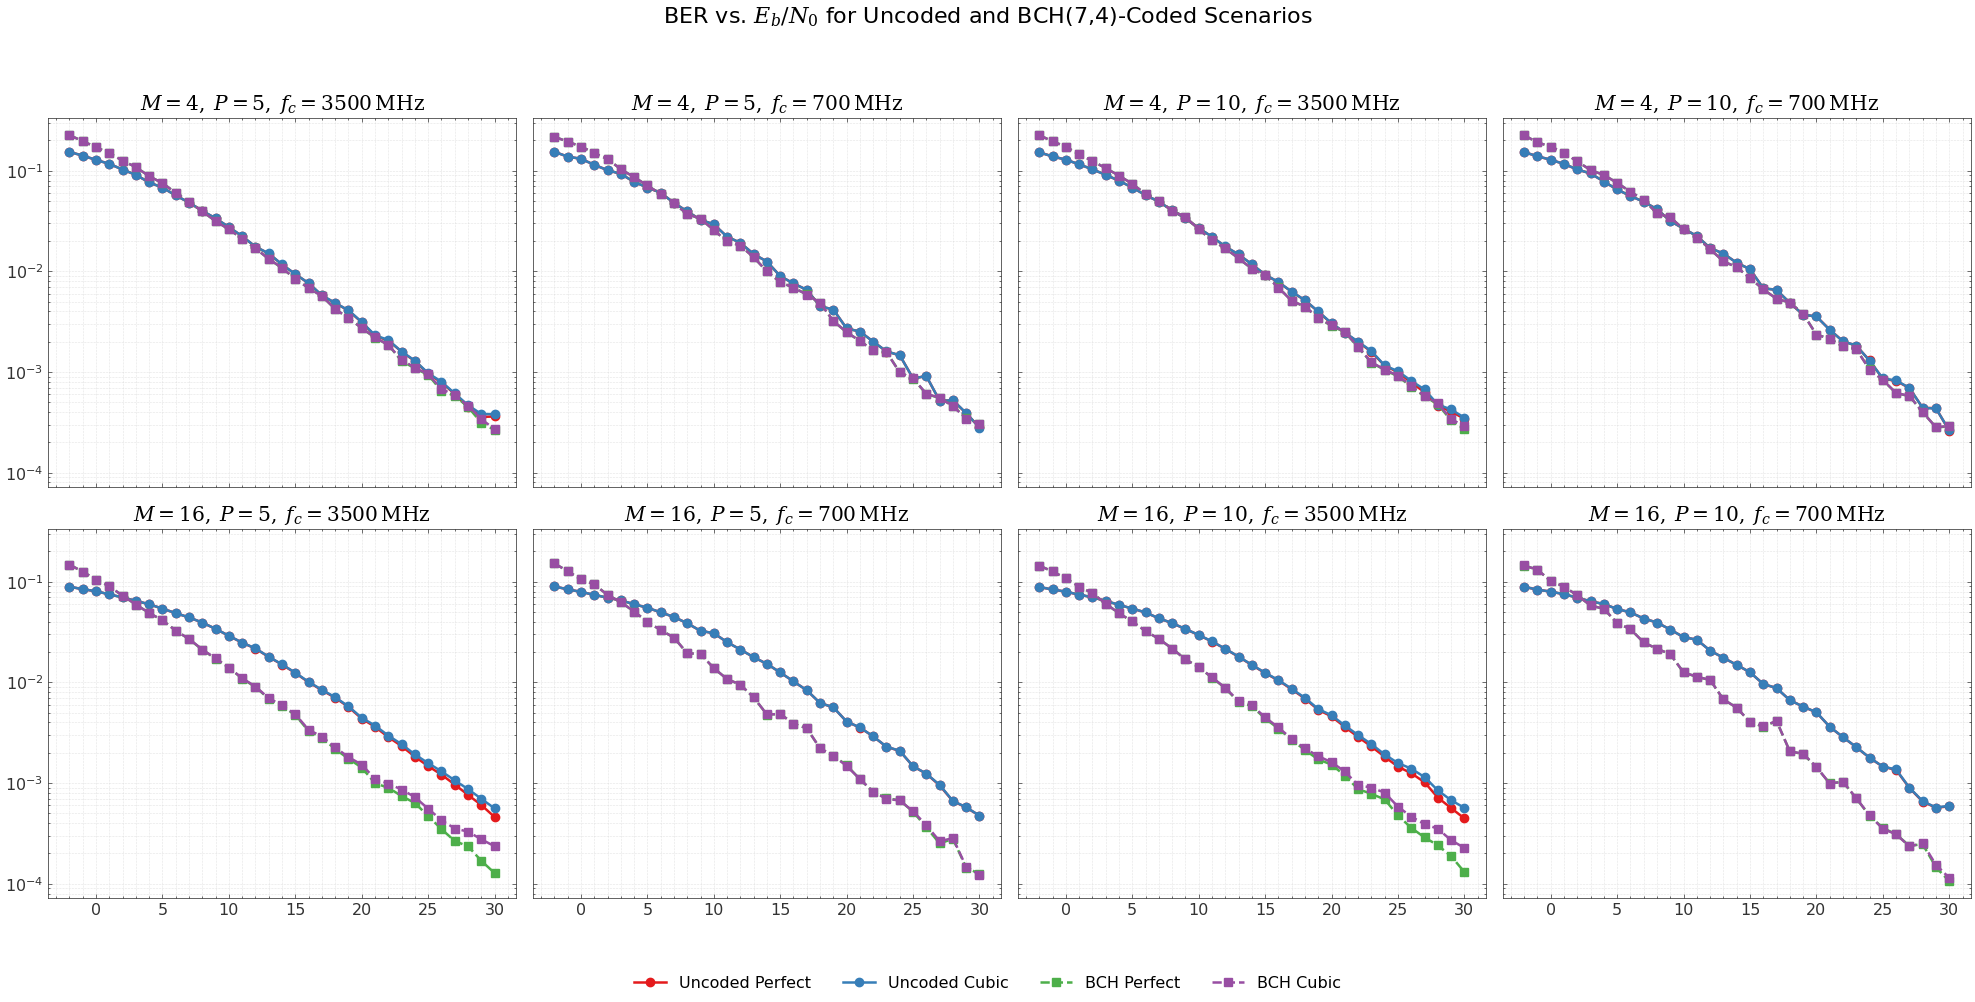

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df_u = pd.read_csv("BER_sweep_results_uncoded_old.csv")
df_b = pd.read_csv("BER_sweep_results_bch_1.csv")

# Parameters
modulations    = sorted(df_u["modulation"].unique())
pilot_spacings = sorted(df_u["pilot_spacing"].unique())
scenarios      = sorted(set(df_u["scenario"]).union(df_b["scenario"]))

# collect up to 8 non‑empty combos
combos = []
for M in modulations:
    for P in pilot_spacings:
        for scen in scenarios:
            sub_u = df_u.query("modulation==@M and pilot_spacing==@P and scenario==@scen")
            sub_b = df_b.query("modulation==@M and pilot_spacing==@P and scenario==@scen")
            if not sub_u.empty or not sub_b.empty:
                combos.append((M, P, scen))
combos = combos[:8]

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)

for ax, (M, P, scen) in zip(axes.flat, combos):
    # pivot & plot uncoded
    tbl = (
        df_u.query("modulation==@M and pilot_spacing==@P and scenario==@scen")
        .pivot_table(index="snr_db", columns="method", values="ber")
        .sort_index()
    )
    for method in ("perfect", "cubic"):
        if method in tbl.columns:
            ax.semilogy(tbl.index, tbl[method],
                        marker="o", linestyle="-",
                        label=f"Uncoded {method.capitalize()}")
    # pivot & plot BCH‑coded
    tbl = (
        df_b.query("modulation==@M and pilot_spacing==@P and scenario==@scen")
        .pivot_table(index="snr_db", columns="method", values="ber")
        .sort_index()
    )
    for method in ("perfect", "cubic"):
        if method in tbl.columns:
            ax.semilogy(tbl.index, tbl[method],
                        marker="s", linestyle="--",
                        label=f"BCH {method.capitalize()}")

    ax.grid(True, which="both", ls=":")
    # --- now parse frequency and set the title *inside* the col loop ---
    freq_token = scen.rsplit("_", 1)[-1]         # "f3500MHz"
    m = re.match(r"f(\d+)([A-Za-z]+)", freq_token)
    if m:
        freq_val, freq_unit = m.groups()
    else:
        freq_val, freq_unit = freq_token, ""
    fc_str = fr"f_c={freq_val}\,\mathrm{{{freq_unit}}}"

    # wrap the *whole* thing once:
    ax.set_title(fr"$M={M},\;P={P},\;{fc_str}$")

# make room at bottom for a single legend
fig.subplots_adjust(bottom=0.12)

# --- add one global legend below the subplots ---
handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi)
            labels.append(li)

fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=4,
    frameon=False,
    fontsize='medium'
)

fig.suptitle(
            "BER vs. $E_b/N_0$ for Uncoded and BCH(7,4)-Coded Scenarios",
            fontsize=16
            )
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

os.makedirs("figures_p3", exist_ok=True)
fig.savefig("figures_p3/BER_all_subplots.png", dpi=500)
print("→ saved figures_p3/BER_all_subplots.png")


→ saved figures_p3/BER_all_subplots_vertical.png


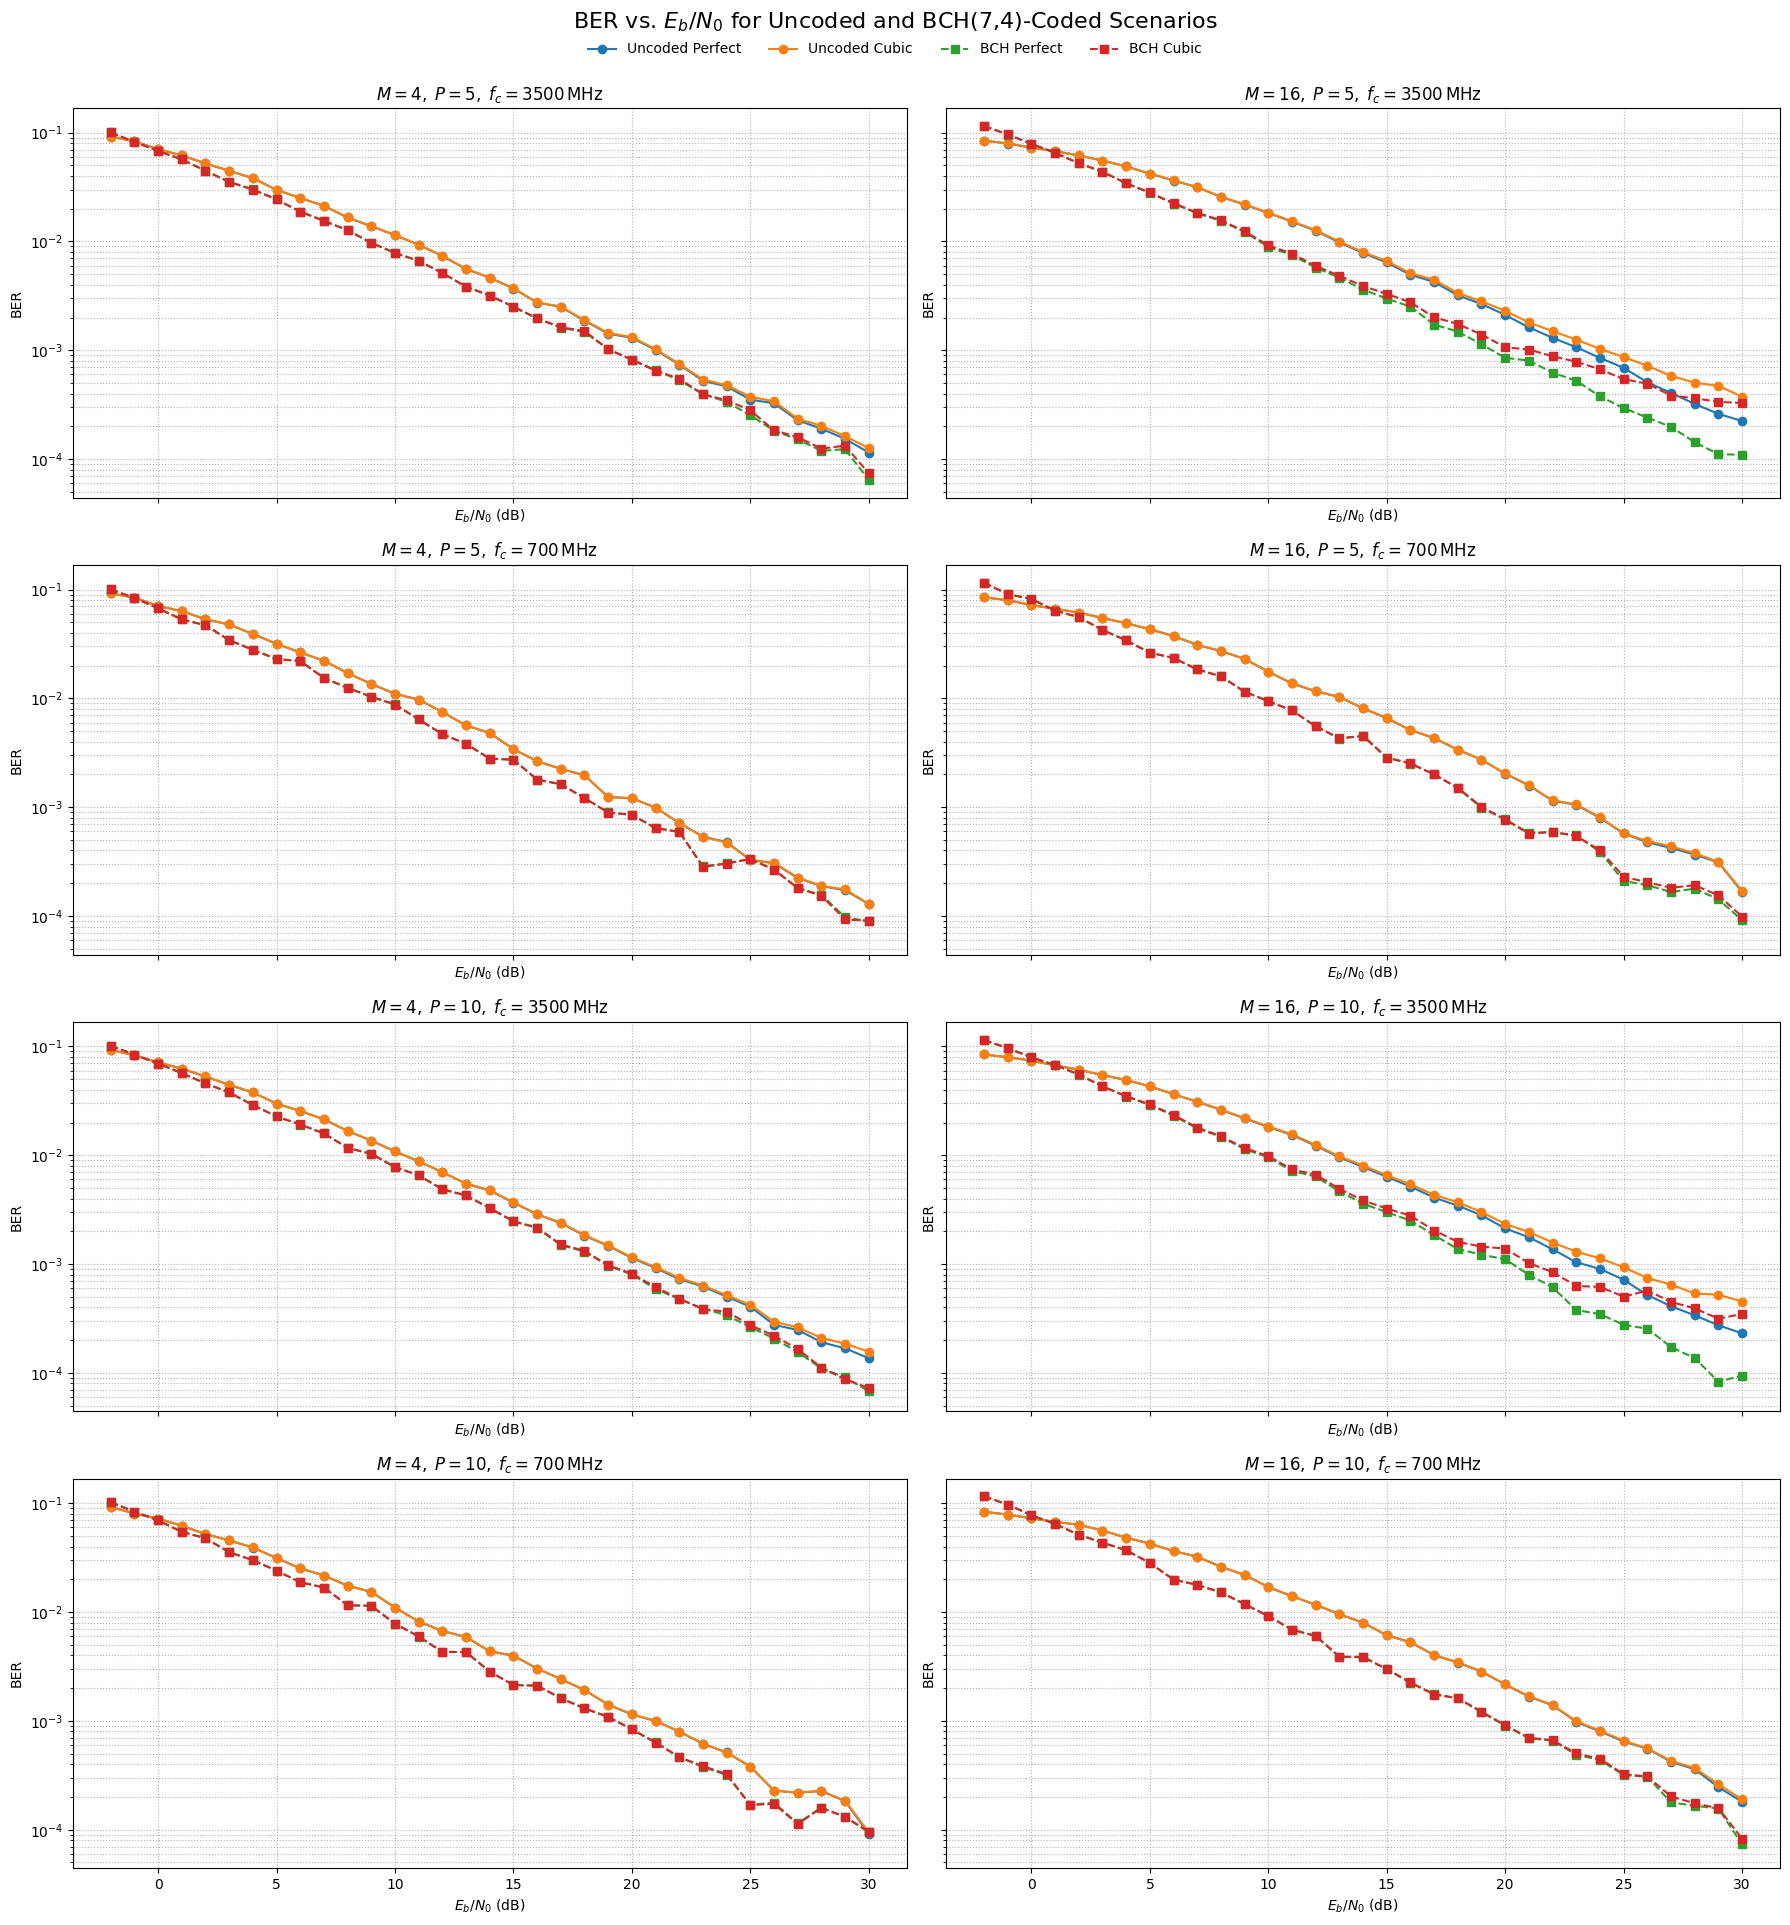

In [14]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df_u = pd.read_csv("BER_sweep_results_fix.csv")
df_b = pd.read_csv("BER_sweep_results_bch_fix2.csv")

# Parameters
modulations    = sorted(df_u["modulation"].unique())   # [4, 16]
pilot_spacings = sorted(df_u["pilot_spacing"].unique())
scenarios      = sorted(set(df_u["scenario"]).union(df_b["scenario"]))

# find (P, scen) pairs that exist for both M=4 and M=16
pairs = []
for P in pilot_spacings:
    for scen in scenarios:
        has4 = (not df_u.query("modulation==4 and pilot_spacing==@P and scenario==@scen").empty or
                not df_b.query("modulation==4 and pilot_spacing==@P and scenario==@scen").empty)
        has16 = (not df_u.query("modulation==16 and pilot_spacing==@P and scenario==@scen").empty or
                 not df_b.query("modulation==16 and pilot_spacing==@P and scenario==@scen").empty)
        if has4 and has16:
            pairs.append((P, scen))
pairs = pairs[:4]  # we need exactly 4 rows

# 4 rows × 2 columns
fig, axes = plt.subplots(4, 2, figsize=(18, 20), sharex=True, sharey=True)

for row, (P, scen) in enumerate(pairs):
    for col, M in enumerate(modulations):
        ax = axes[row, col]

        # plot uncoded
        tbl = (
            df_u.query("modulation==@M and pilot_spacing==@P and scenario==@scen")
                .pivot_table(index="snr_db", columns="method", values="ber")
                .sort_index()
        )
        for method in ("perfect", "cubic"):
            if method in tbl.columns:
                ax.semilogy(tbl.index, tbl[method],
                            marker="o", linestyle="-",
                            label=f"Uncoded {method.capitalize()}")
        # plot BCH‑coded
        tbl = (
            df_b.query("modulation==@M and pilot_spacing==@P and scenario==@scen")
                .pivot_table(index="snr_db", columns="method", values="ber")
                .sort_index()
        )
        for method in ("perfect", "cubic"):
            if method in tbl.columns:
                ax.semilogy(tbl.index, tbl[method],
                            marker="s", linestyle="--",
                            label=f"BCH {method.capitalize()}")

        ax.grid(True, which="both", ls=":")

        # --- now parse frequency and set the title *inside* the col loop ---
        freq_token = scen.rsplit("_", 1)[-1]         # "f3500MHz"
        m = re.match(r"f(\d+)([A-Za-z]+)", freq_token)
        if m:
            freq_val, freq_unit = m.groups()
        else:
            freq_val, freq_unit = freq_token, ""
        fc_str = fr"f_c={freq_val}\,\mathrm{{{freq_unit}}}"

        # wrap the *whole* thing once:
        ax.set_title(fr"$M={M},\;P={P},\;{fc_str}$")
        ax.set_xlabel("$E_b/N_0$ (dB)")
        ax.set_ylabel("BER")
    
# 1) reserve space at the top for title + legend
fig.subplots_adjust(top=0.94)

# 2) overall title
fig.suptitle(
    "BER vs. $E_b/N_0$ for Uncoded and BCH(7,4)-Coded Scenarios",
    fontsize=16,
    y=0.96
)

# 3) collect one global legend
handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi)
            labels.append(li)

# 4) put legend under the title
fig.legend(
    handles, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.95),
    ncol=4,
    frameon=False,
    fontsize="medium"
)

# 5) tighten layout below legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save
os.makedirs("figures_p3", exist_ok=True)
fig.savefig("figures_p3/BER_all_subplots_vertical.png", dpi=300)
print("→ saved figures_p3/BER_all_subplots_vertical.png")


→ saved figures_p3/BER_by_scenario_modulations_together.png


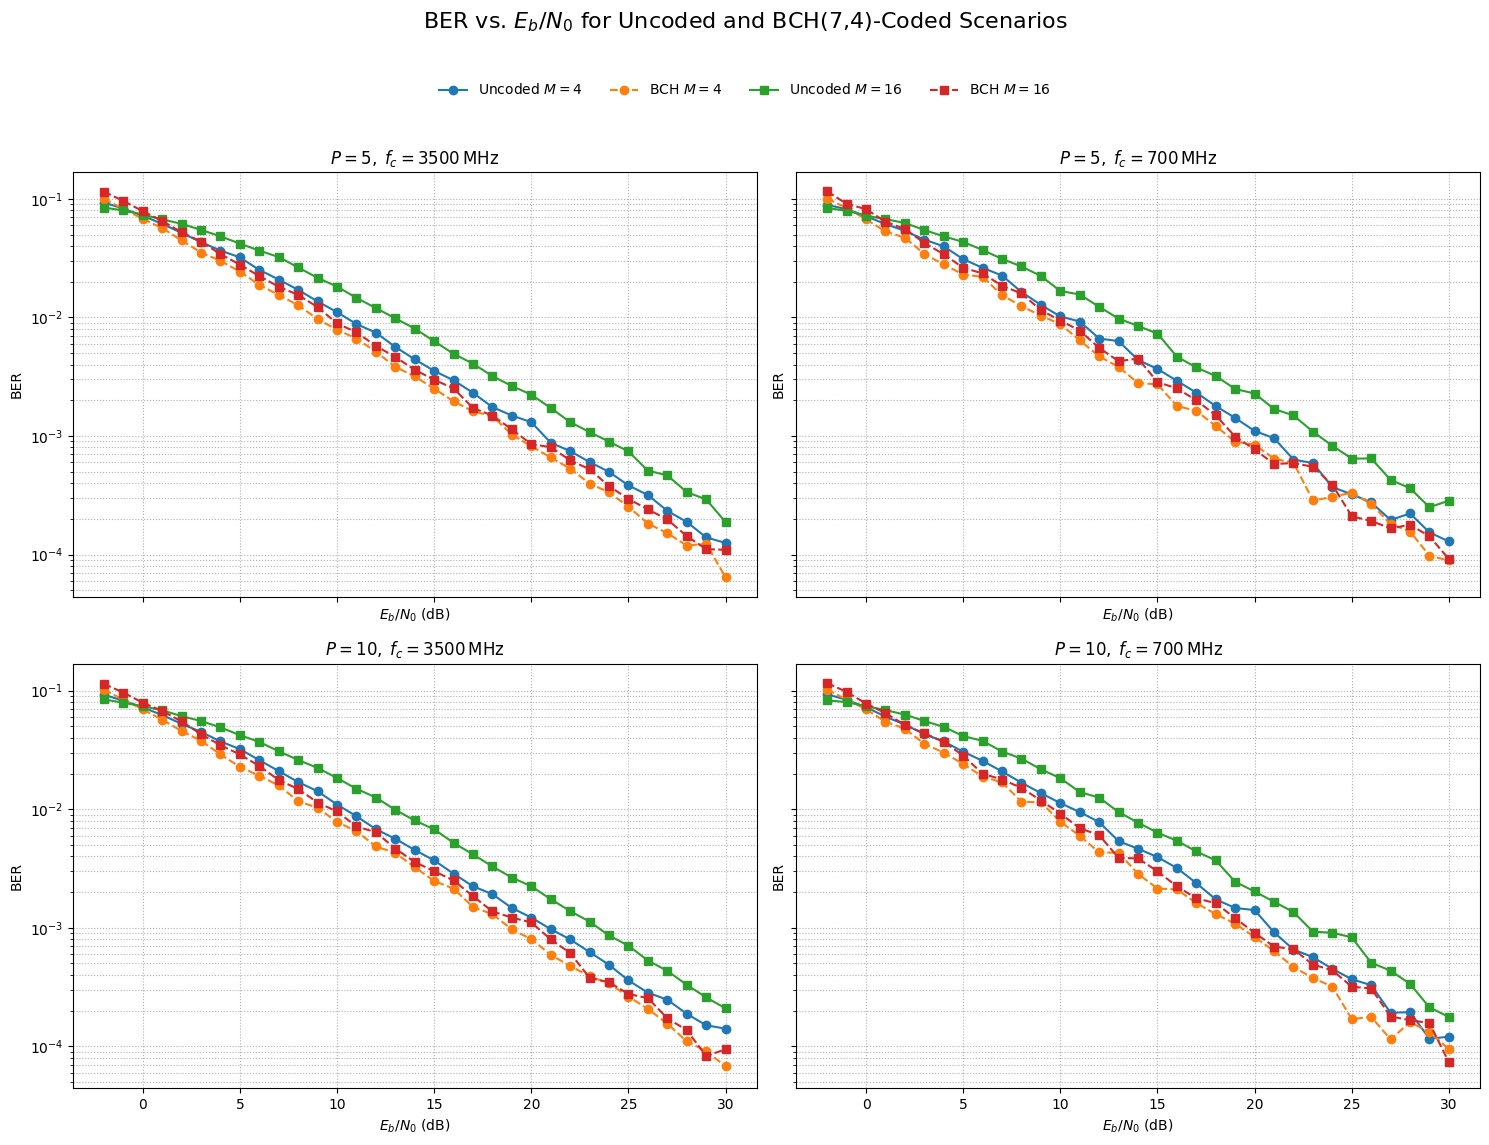

In [12]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df_u = pd.read_csv("BER_sweep_results_test.csv")
df_b = pd.read_csv("BER_sweep_results_bch_fix2.csv")

# Parameters
modulations    = sorted(df_u["modulation"].unique())   # [4, 16]
pilot_spacings = sorted(df_u["pilot_spacing"].unique())
scenarios      = sorted(set(df_u["scenario"]).union(df_b["scenario"]))

# Find the first 4 (P, scen) that exist for both M=4 and M=16
pairs = []
for P in pilot_spacings:
    for scen in scenarios:
        has4 = (not df_u.query("modulation==4 and pilot_spacing==@P and scenario==@scen").empty or
                not df_b.query("modulation==4 and pilot_spacing==@P and scenario==@scen").empty)
        has16 = (not df_u.query("modulation==16 and pilot_spacing==@P and scenario==@scen").empty or
                 not df_b.query("modulation==16 and pilot_spacing==@P and scenario==@scen").empty)
        if has4 and has16:
            pairs.append((P, scen))
pairs = pairs[:4]

# Build 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

for ax, (P, scen) in zip(axes.flat, pairs):
    for M, mark in zip(modulations, ("o", "s")):
        # Uncoded (perfect)
        dfu = df_u.query("modulation==@M and pilot_spacing==@P and scenario==@scen")
        if not dfu.empty:
            u_tbl = (
                dfu
                .pivot_table(index="snr_db", columns="method", values="ber")
                .sort_index()
            )
            if "perfect" in u_tbl.columns:
                ax.semilogy(
                    u_tbl.index, u_tbl["perfect"],
                    marker=mark, linestyle="-",
                    label=f"Uncoded $M={M}$"
                )

        # BCH‐coded (perfect)
        dfb = df_b.query("modulation==@M and pilot_spacing==@P and scenario==@scen")
        if not dfb.empty:
            b_tbl = (
                dfb
                .pivot_table(index="snr_db", columns="method", values="ber")
                .sort_index()
            )
            if "perfect" in b_tbl.columns:
                ax.semilogy(
                    b_tbl.index, b_tbl["perfect"],
                    marker=mark, linestyle="--",
                    label=f"BCH $M={M}$"
                )

    ax.grid(True, which="both", ls=":")
    ax.set_xlabel("$E_b/N_0$ (dB)")
    ax.set_ylabel("BER")

    # build the P/fc subtitle
    freq_token = scen.rsplit("_", 1)[-1]        # e.g. "f3500MHz"
    m = re.match(r"f(\d+)([A-Za-z]+)", freq_token)
    if m:
        val, unit = m.groups()
    else:
        val, unit = freq_token, ""
    fc = fr"f_c={val}\,\mathrm{{{unit}}}"
    ax.set_title(fr"$P={P},\;{fc}$")

# Master title + legend
fig.subplots_adjust(top=0.88)
fig.suptitle(
    "BER vs. $E_b/N_0$ for Uncoded and BCH(7,4)-Coded Scenarios",
    fontsize=16, y=0.95
)

# single legend
handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi)
            labels.append(li)

fig.legend(
    handles, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.90),
    ncol=4, frameon=False, fontsize="medium"
)

# tighten everything below the legend line
fig.tight_layout(rect=[0, 0, 1, 0.88])

# Save
os.makedirs("figures_p3", exist_ok=True)
out = "figures_p3/BER_by_scenario_modulations_together.png"
fig.savefig(out, dpi=300)
print(f"→ saved {out}")


→ saved figures_p3/BER_uncoded_perfect_only.png


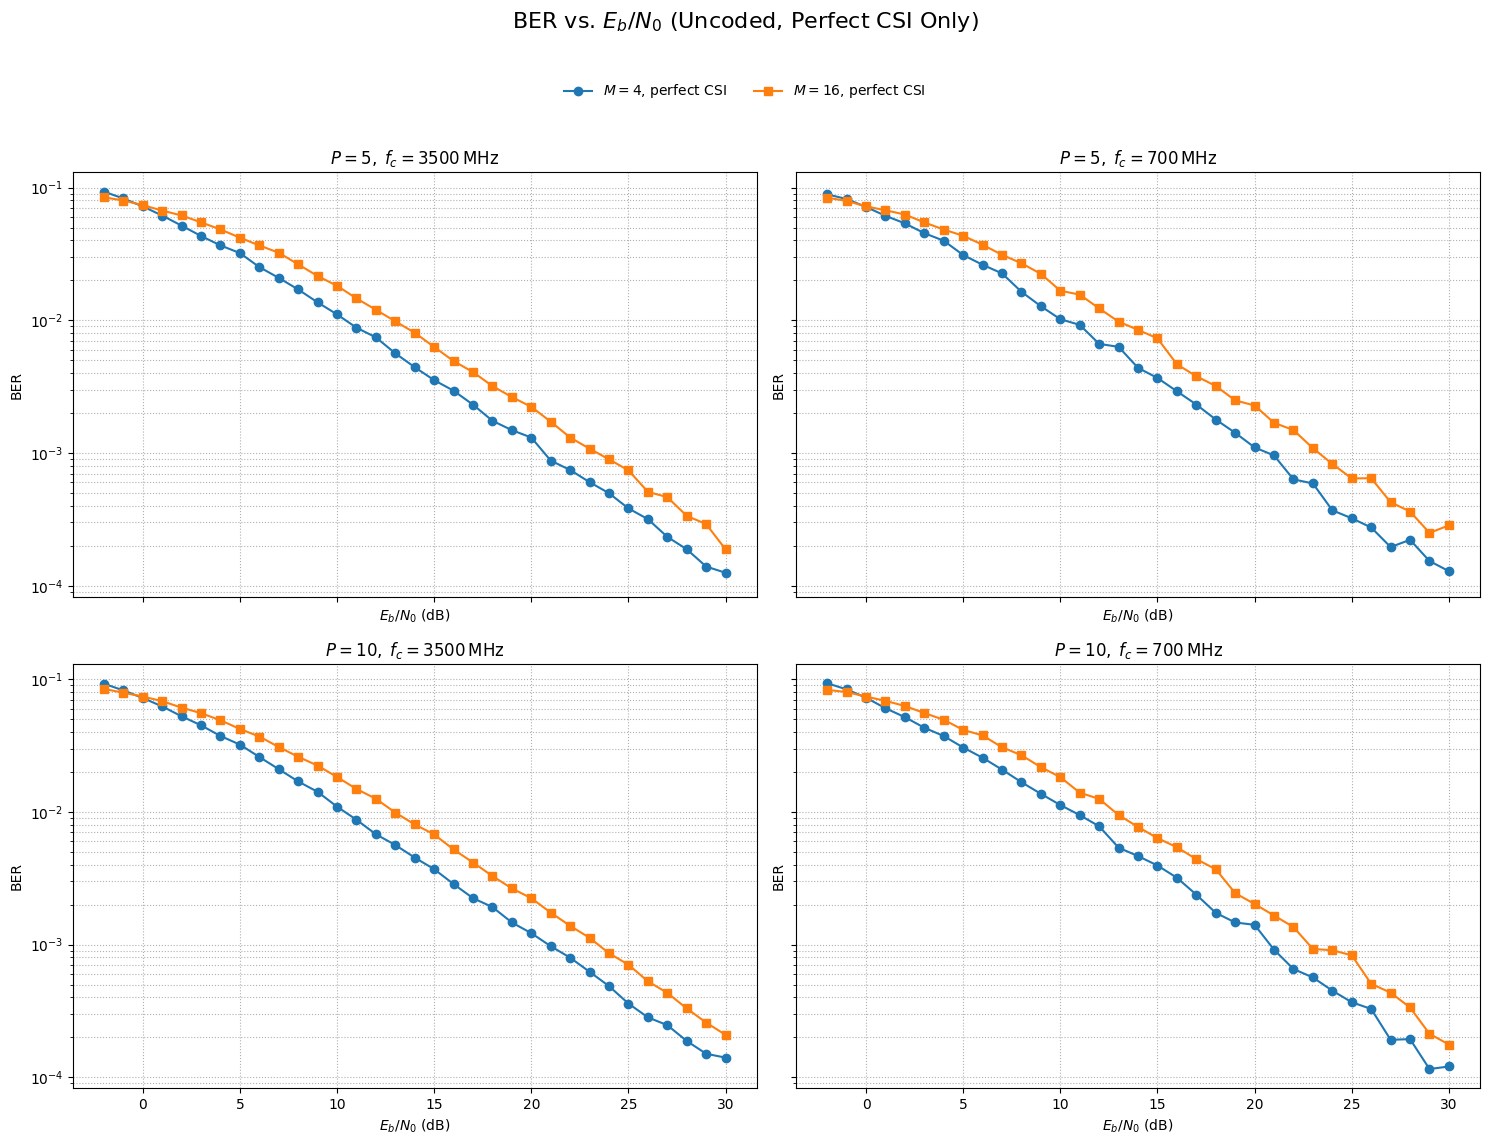

In [8]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df_u = pd.read_csv("BER_sweep_results_test.csv")

# Parameters
modulations    = sorted(df_u["modulation"].unique())   # [4, 16]
pilot_spacings = sorted(df_u["pilot_spacing"].unique())
scenarios      = sorted(df_u["scenario"].unique())

# Find the first 4 (P, scen) pairs that exist for both modulations
pairs = []
for P in pilot_spacings:
    for scen in scenarios:
        has4  = not df_u.query("modulation==4  and pilot_spacing==@P and scenario==@scen").empty
        has16 = not df_u.query("modulation==16 and pilot_spacing==@P and scenario==@scen").empty
        if has4 and has16:
            pairs.append((P, scen))
pairs = pairs[:4]

# Build 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

for ax, (P, scen) in zip(axes.flat, pairs):
    for M, marker in zip(modulations, ("o", "s")):
        tbl = (
            df_u
            .query("modulation==@M and pilot_spacing==@P and scenario==@scen")
            .pivot_table(index="snr_db", columns="method", values="ber")
            .sort_index()
        )
        if "perfect" in tbl.columns:
            ax.semilogy(
                tbl.index, tbl["perfect"],
                marker=marker, linestyle="-",
                label=f"$M={M}$, perfect CSI"
            )

    ax.grid(True, which="both", ls=":")
    ax.set_xlabel("$E_b/N_0$ (dB)")
    ax.set_ylabel("BER")

    # subtitle: P and f_c
    freq_token = scen.rsplit("_", 1)[-1]        # e.g. "f3500MHz"
    m = re.match(r"f(\d+)([A-Za-z]+)", freq_token)
    if m:
        val, unit = m.groups()
    else:
        val, unit = freq_token, ""
    fc = fr"f_c={val}\,\mathrm{{{unit}}}"
    ax.set_title(fr"$P={P},\;{fc}$")

# Master title + legend
fig.subplots_adjust(top=0.88)
fig.suptitle(
    "BER vs. $E_b/N_0$ (Uncoded, Perfect CSI Only)",
    fontsize=16, y=0.95
)

# single legend
handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi)
            labels.append(li)

fig.legend(
    handles, labels,
    loc="upper center", bbox_to_anchor=(0.5, 0.90),
    ncol=2, frameon=False, fontsize="medium"
)

# tighten everything below legend
fig.tight_layout(rect=[0, 0, 1, 0.88])

# Save
os.makedirs("figures_p3", exist_ok=True)
out = "figures_p3/BER_uncoded_perfect_only.png"
fig.savefig(out, dpi=300)
print(f"→ saved {out}")
